In [1]:
# import os
# os.environ['KAGGLE_CONFIG_DIR'] = '/content'
# !chmod 600 '/content/kaggle.json'
# !kaggle datasets download -d mariafrenti/age-prediction
# !unzip -q age-prediction.zip
# !rm age-prediction.zip

100% 2.02G/2.03G [00:55<00:00, 65.3MB/s]
100% 2.03G/2.03G [00:55<00:00, 39.2MB/s]


In [2]:
SEED = 1001

import numpy as np
import pandas as pd
import os
os.environ['PYTHONHASHSEED'] = str(SEED)
import tensorflow as tf
import random as python_random
from tensorflow import keras
from keras import layers
from sklearn.model_selection import KFold, train_test_split
import matplotlib.pyplot as plt
import math
# Typings
from typing import Tuple, Callable, List, Union, Dict, Iterable, Iterator, Optional
from tensorflow.python.data.ops.dataset_ops import BatchDataset
import functools
import seaborn as sns
from glob2 import glob


# Padronizando a aleatoriedade
rng = np.random.default_rng(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
python_random.seed(SEED)

In [3]:
NUM_OF_COLOR_CHANNELS = 3
IMAGE_SIZE = (128, 128)
BATCH_SIZE = 32
INPUT_SHAPE = (*IMAGE_SIZE, NUM_OF_COLOR_CHANNELS)
BATCH_INPUT_SHAPE = (None, *INPUT_SHAPE)

'''
    Retorna um Dataset com base nos arquivos dos diretórios.
    - path: caminho base para as pastas
'''
def _load_data(path: str, subset: str = None, validation_split: float = None) -> tf.data.Dataset:
    return keras.preprocessing.image_dataset_from_directory(
        path,
        seed=SEED,
        validation_split=validation_split,
        subset=subset,
        image_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        shuffle=True,
    )
_20to50_dir = "20-50/20-50"
_1to100_dir = "age_prediction_up/age_prediction"


'''
    Retorna um Dataset com as imagens e labels já apropriados para treinamento
    - all_ages: se deve ser usado o diretório com idades de 1 a 100
    - train: se deve ser usado o conjunto de treino
    (será usado teste caso contrário)
    - regression: se os labels devem ser transformados para tarefas de regressão
    (será transformado para classificação caso contrário)
'''
def load_data(all_ages: bool, train: bool, regression: bool, subset: str = None, validation_split: float = None) -> tf.data.Dataset:
    base_dir = _1to100_dir if all_ages else _20to50_dir
    folder = "train" if train else "test"
    age_count = 100 if all_ages else 31
    data = _load_data(f"{base_dir}/{folder}", subset, validation_split)
    if regression:
        return data.map(lambda x, y: (x, y / (age_count - 1)))
    return data.map(lambda x, y: (x, tf.one_hot(y, depth=age_count)))

In [4]:

''' Retorna uma np.ndarray com todos os caminhos até as imagens '''
def get_image_paths(all_ages: bool, train: bool) -> np.ndarray:
    base_dir = _1to100_dir if all_ages else _20to50_dir
    folder = "train" if train else "test"
    return np.array(sorted(glob(f'{base_dir}/{folder}/*/*.jpg')))

'''
    Retorna a imagem e o label associado a um caminho.
    O label já é transformado apropriadamente
'''
def load_image(path: str, regression: bool, num_of_groups: Optional[int] = None):
    parts = path.split(os.sep)
    age = int(parts[3])
    all_ages = parts[0] != '20-50'
    age_count = 100 if all_ages else 31
    offset = 1 if all_ages else 20
    if regression:
        label = tf.convert_to_tensor((age - offset) / (age_count - 1))
    else:
        num_of_groups = num_of_groups if num_of_groups is not None else age_count
        _label = int((age - offset) / num_of_groups)
        if _label >= num_of_groups:
            _label = num_of_groups - 1
        label = tf.one_hot(_label, depth=num_of_groups)
    image = tf.io.read_file(path)
    image = tf.image.decode_png(image, channels=3)
    return image, label

'''
    Retorna um gerador que pode ser usado para iterar por todas as imagens
    nos caminhos especificados.
    Construa um Dataset com tf.data.Dataset.from_generator
'''
def build_images_generator(paths: List[str], regression: bool, num_of_groups: Optional[int] = None):
    def gen():
        i = 0
        num_of_files = len(paths)
        while i < num_of_files:
            yield load_image(paths[i], regression, num_of_groups)
            i += 1
    return gen

'''
    Retorna um Dataset com todas as imagens e seus respectivos labels (já transformados)

'''
def build_ds_from_paths(paths: List[str], regression: bool, num_of_groups: Optional[int] = None, batch_size=BATCH_SIZE) -> tf.data.Dataset:
    all_ages = paths[0].split(os.sep)[0] != '20-50'
    age_count = 100 if all_ages else 31
    label_shape = () if regression else (age_count,)
    input_shape = INPUT_SHAPE
    return tf.data.Dataset.from_generator(
        build_images_generator(paths, regression, num_of_groups),
        output_types=(tf.uint8, tf.float32), 
        output_shapes=(input_shape, label_shape),
    ).batch(BATCH_SIZE)

def build_ds_from_index(index: List[int], all_ages: bool, train: bool, regression: bool, num_of_groups: Optional[int] = None, batch_size=BATCH_SIZE) -> tf.data.Dataset:
    paths = get_image_paths(all_ages, train)[index]
    return build_ds_from_paths(paths, regression, num_of_groups, batch_size)

'''
    Mapeia labels ou predições, que são valores em [0, 1], para idades.
    Na classificação, há codificação one-hot

    A idade retornada na classificação é aquela associada à classe
    com maior propabilidade.
'''
def map_to_ages(labels, all_ages: bool, regression: bool):
    scale = (99 if all_ages else 30) if regression else 1
    offset = 1 if all_ages else 20
    if not regression:
        labels = np.argmax(labels, axis=-1)
    return labels * scale + offset

In [5]:
SAMPLE_SIZE = 5000
validation_split = 0.2

train_paths = get_image_paths(all_ages=False, train=True)
train_paths_sample = np.random.choice(train_paths, SAMPLE_SIZE)

tr_paths, valid_paths = train_test_split(train_paths_sample, test_size=0.2)

sample_ds_train = build_ds_from_paths(tr_paths, regression=True)
sample_ds_valid = build_ds_from_paths(valid_paths, regression=True)

NUM_OF_GROUPS = 3 # [20, 30) | [30, 40) | [40, 50]
sample_ds_train_c = build_ds_from_paths(tr_paths, regression=False, num_of_groups=NUM_OF_GROUPS)
sample_ds_valid_c = build_ds_from_paths(valid_paths, regression=False, num_of_groups=NUM_OF_GROUPS)

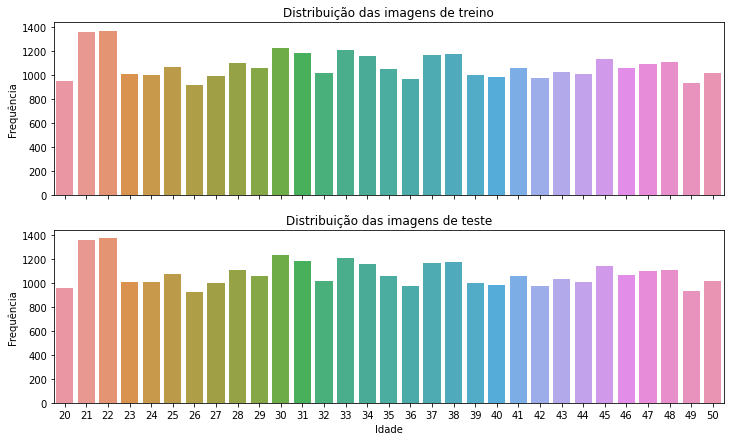

In [6]:
def count_images(train: bool, age: int):
    folder = 'train' if train else 'test'
    return len(glob(f'./20-50/20-50/{folder}/{age}/*.jpg'))

train_images_per_age = [count_images(train=True, age=age) for age in range(20, 51)]
test_images_per_age = [count_images(train=True, age=age) for age in range(20, 51)]

_, axs = plt.subplots(figsize=(12, 7), nrows=2, sharex=True, sharey=True)
axs[0].set_title('Distribuição das imagens de treino')
axs[0].set_ylabel('Frequência')
axs[1].set_xlabel('Idade')
axs[1].set_ylabel('Frequência')
axs[1].set_title('Distribuição das imagens de teste')
sns.barplot(x=list(range(20, 51)), y=train_images_per_age, ax=axs[0])
sns.barplot(x=list(range(20, 51)), y=test_images_per_age, ax=axs[1])

In [28]:
_only_normalization = keras.Sequential([
    layers.Rescaling(1./255, batch_input_shape=BATCH_INPUT_SHAPE)
], name='only_normalization')

def build_preprocess(strenght: float = 0.1):
    return keras.Sequential(
    [
        layers.Resizing(*IMAGE_SIZE, batch_input_shape=BATCH_INPUT_SHAPE),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(strenght),
        layers.RandomTranslation(strenght, strenght),
        layers.RandomZoom(strenght, strenght),
        layers.RandomContrast(strenght),
        _only_normalization,
    ], name='preprocess'
)

In [8]:
def batchify(image: np.ndarray) -> np.ndarray:
    if len(image.shape) == len(INPUT_SHAPE):
        # o modelo (incluindo pré-processamento) espera a entrada em mini-batches
        # caso uma única imagem seja passada, modificamos seu formato
        # para 1 batch de 1 imagem
        image = np.expand_dims(image, axis=0)
    return image

'''
    Exibe uma image.
'''
def plot_single_image(image: np.ndarray, age: Optional[int] = None, apply=None):
    if apply is not None:
        image = apply(batchify(image))[0]
    fig, ax = plt.subplots()
    ax.imshow(image)
    if age is not None:
        ax.set_title(age)
    ax.axis("off")

def plot_samples(images, ages: Iterable[int], all_ages: bool, regression: bool, ncols=4, apply=None):
    if ncols > len(images):
        ncols = len(images)
    nrows = math.ceil(len(images) / ncols)
    N = nrows * ncols
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(2 * ncols, 2.5 * nrows), squeeze=False)
    axs = axs.ravel()
    for i, (image, label) in enumerate(zip(images, ages)):
        if i >= N:
            break
        image = image.numpy()
        axs[i].imshow(image)
        age = map_to_ages(label, all_ages=all_ages, regression=regression)
        axs[i].set_title(int(float(age)))
        axs[i].axis("off")
    
def extract_first_batch(ds):
    for image, age in ds:
        return image, age

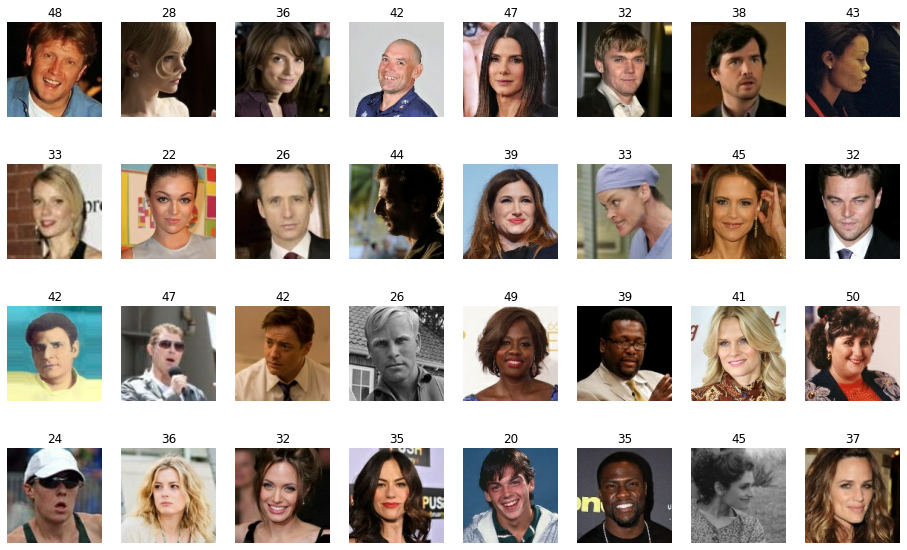

In [ ]:
_images, _ages = extract_first_batch(sample_ds_train)
plot_samples(_images, _ages, all_ages=False, regression=True, ncols=8)

In [29]:
def build_model(
    inputs,
    num_of_conv_layers_per_block: int,
    num_of_blocks: int,
    initial_filter: int,
    num_of_hidden_layers: int,
    neurons_per_hidden_layer: int, 
    dense_activation: str,
    output_activation: str,
    dropout: Optional[float] = None,
    # se o número de filtros é constante ou dobra a cada bloco
    fixed_size_filter: bool = False,
    use_batch_normalization = False,
    last_dense_neurons_count = 1,
    preprocess_strenght = 0.1,
):
    dropout = None if dropout == 0 else dropout

    KERNEL_SIZE = 3
    CONV_ACTIVATION = 'relu'
    CONV_PADDING = 'same'
    POOL_SIZE = 2
    BATCH_INPUT_SHAPE = (*IMAGE_SIZE, 3)

    x = build_preprocess(preprocess_strenght)(inputs)

    all_blocks = []
    filters = initial_filter
    for i in range(num_of_blocks):
        block = [
            layers.Conv2D(
                filters,
                KERNEL_SIZE,
                padding=CONV_PADDING,
                batch_input_shape=BATCH_INPUT_SHAPE,
                activation=CONV_ACTIVATION
            )
            for j in range(num_of_conv_layers_per_block)
        ]
        if use_batch_normalization:
            block.append(layers.BatchNormalization())
        block.append(layers.MaxPooling2D(pool_size=POOL_SIZE))

        all_blocks.append(block)
        if not fixed_size_filter:
            filters *= 2
    
    for block in all_blocks:
        for layer in block:
            x = layer(x)
    
    
    x = layers.Flatten()(x)

    for i in range(num_of_hidden_layers):
        x = layers.Dense(neurons_per_hidden_layer, activation=dense_activation)(x)
        if dropout is not None:
            x = layers.Dropout(dropout)(x)

    x = layers.Dense(last_dense_neurons_count, activation=output_activation)(x)
        
    return keras.models.Model(inputs=inputs, outputs=x)

In [30]:
def get_random_hyperparameters(count: int, seed: int = 3621264):
    rng = np.random.default_rng(seed=seed)
    for i in range(count):
        yield {
            'num_of_conv_layers_per_block': rng.choice([1, 2, 3]),
            'num_of_blocks': rng.choice([1, 2, 3]),
            'num_of_hidden_layers': rng.choice([1, 2, 3]),
            'neurons_per_hidden_layer': rng.choice([16, 32, 64, 128, 256]),
            'initial_filter': rng.choice([8, 16, 32, 64]),
            'dropout': rng.choice([0, 0.1, 0.5]),
            'fixed_size_filter': rng.choice([False, True]),
            'use_batch_normalization': rng.choice([False, True]),
            'dense_activation': rng.choice(['tanh', 'relu']),
        }

list(get_random_hyperparameters(2, seed=1))

[{'dense_activation': 'tanh',
  'dropout': 0.0,
  'fixed_size_filter': True,
  'initial_filter': 8,
  'neurons_per_hidden_layer': 256,
  'num_of_blocks': 2,
  'num_of_conv_layers_per_block': 2,
  'num_of_hidden_layers': 3,
  'use_batch_normalization': True},
 {'dense_activation': 'relu',
  'dropout': 0.0,
  'fixed_size_filter': False,
  'initial_filter': 64,
  'neurons_per_hidden_layer': 32,
  'num_of_blocks': 3,
  'num_of_conv_layers_per_block': 1,
  'num_of_hidden_layers': 2,
  'use_batch_normalization': True}]

In [31]:
def train_model_R(model, epochs: int, train_data: tf.data.Dataset, valid_data: tf.data.Dataset):
    optimizer = keras.optimizers.Adam(learning_rate=0.001)
    loss = keras.losses.MSE
    model.compile(optimizer=optimizer, loss=loss)
    return model.fit(train_data, epochs=epochs, validation_data=valid_data)


In [32]:
class Losses:
    @staticmethod
    def RMSE(real: np.ndarray, pred: np.ndarray) -> float:
        return np.sqrt(np.mean((real - pred) ** 2))

    @staticmethod
    def MAE(real: np.ndarray, pred: np.ndarray) -> float:
        return np.mean(np.abs(real - pred))
    
    @staticmethod
    def regression(real: np.ndarray, pred: np.ndarray) -> pd.Series:
        return pd.Series({
            'RMSE': Losses.RMSE(real, pred),
            'MAE': Losses.MAE(real, pred),
        }, name='losses')

In [33]:
train_data_R = sample_ds_train
valid_data_R = sample_ds_valid
inputs_R = layers.Input(shape=(None, None, 3), dtype='uint8')

In [35]:
def RandomSearch_R(tr, val, model_amount: int = 30, epochs: int = 10, n_folds: int = 5, preprocess_strenght = 0.1):
    models = []
    inputs_R = layers.Input(shape=(None, None, 3), dtype='uint8')
    loss_R = np.ndarray(model_amount)
    hyperparams_R = list(get_random_hyperparameters(count=model_amount))
    for i in range(model_amount):
        print(f"Hiperparâmetros Selecionados:\n{hyperparams_R[i]}")
        model_R = build_model(inputs_R, **hyperparams_R[i], output_activation = 'sigmoid', preprocess_strenght=preprocess_strenght)
        history_R = train_model_R(model_R, epochs, train_data = tr, valid_data = val)
        models.append(model_R)
        loss_R[i] = history_R.history['val_loss'][-1]
    idx_R = np.argmin(loss_R)
    selected_hyperparams = hyperparams_R[idx_R]
    return selected_hyperparams, models[idx_R]

In [20]:
# Pré-processamento leve
selected_hyper, selected_model = RandomSearch_R(train_data_R, valid_data_R)

Hiperparâmetros Selecionados:
{'num_of_conv_layers_per_block': 2, 'num_of_blocks': 3, 'num_of_hidden_layers': 1, 'neurons_per_hidden_layer': 32, 'initial_filter': 8, 'dropout': 0.1, 'fixed_size_filter': True, 'use_batch_normalization': True, 'dense_activation': 'tanh'}
Epoch 1/10
125/125 [==============================] - 22s 67ms/step - loss: 0.1174 - val_loss: 0.0901
Epoch 2/10
125/125 [==============================] - 8s 61ms/step - loss: 0.1040 - val_loss: 0.1009
Epoch 3/10
125/125 [==============================] - 8s 66ms/step - loss: 0.1033 - val_loss: 0.1101
Epoch 4/10
125/125 [==============================] - 8s 61ms/step - loss: 0.1012 - val_loss: 0.0886
Epoch 5/10
125/125 [==============================] - 8s 63ms/step - loss: 0.0993 - val_loss: 0.0888
Epoch 6/10
125/125 [==============================] - 10s 79ms/step - loss: 0.0988 - val_loss: 0.0863
Epoch 7/10
125/125 [==============================] - 8s 65ms/step - loss: 0.0965 - val_loss: 0.0852
Epoch 8/10
125/125 [=

In [36]:
# Pré-processamento forte
selected_hyper2, selected_model2 = RandomSearch_R(train_data_R, valid_data_R, preprocess_strenght=0.5)

Hiperparâmetros Selecionados:
{'num_of_conv_layers_per_block': 2, 'num_of_blocks': 3, 'num_of_hidden_layers': 1, 'neurons_per_hidden_layer': 32, 'initial_filter': 8, 'dropout': 0.1, 'fixed_size_filter': True, 'use_batch_normalization': True, 'dense_activation': 'tanh'}
Epoch 1/10
125/125 [==============================] - 9s 62ms/step - loss: 0.1137 - val_loss: 0.0902
Epoch 2/10
125/125 [==============================] - 7s 60ms/step - loss: 0.1022 - val_loss: 0.1015
Epoch 3/10
125/125 [==============================] - 7s 58ms/step - loss: 0.1020 - val_loss: 0.1085
Epoch 4/10
125/125 [==============================] - 7s 60ms/step - loss: 0.1017 - val_loss: 0.0985
Epoch 5/10
125/125 [==============================] - 7s 60ms/step - loss: 0.0991 - val_loss: 0.0880
Epoch 6/10
125/125 [==============================] - 7s 58ms/step - loss: 0.0986 - val_loss: 0.0876
Epoch 7/10
125/125 [==============================] - 7s 60ms/step - loss: 0.0968 - val_loss: 0.0880
Epoch 8/10
125/125 [===

In [ ]:
selected_model.save('savedmodel')
!zip -r savedmodel.zip savedmodel
from google.colab import files
files.download('savedmodel.zip')

INFO:tensorflow:Assets written to: savedmodel/assets
  adding: savedmodel/ (stored 0%)
  adding: savedmodel/assets/ (stored 0%)
  adding: savedmodel/keras_metadata.pb (deflated 93%)
  adding: savedmodel/variables/ (stored 0%)
  adding: savedmodel/variables/variables.data-00000-of-00001 (deflated 28%)
  adding: savedmodel/variables/variables.index (deflated 70%)
  adding: savedmodel/saved_model.pb (deflated 90%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
print(selected_model.summary())
_history = train_model_R(selected_model, epochs=40, train_data = train_data_R, valid_data = valid_data_R)

Model: "model_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 preprocess (Sequential)     (None, 128, 128, 3)       0         
                                                                 
 conv2d_145 (Conv2D)         (None, 128, 128, 8)       608       
                                                                 
 conv2d_146 (Conv2D)         (None, 128, 128, 8)       584       
                                                                 
 conv2d_147 (Conv2D)         (None, 128, 128, 8)       584       
                                                                 
 batch_normalization_25 (Bat  (None, 128, 128, 8)      32        
 chNormalization)                                                
                                                          

In [ ]:
def train_model_C(model, epochs: int, train_data: tf.data.Dataset, valid_data: tf.data.Dataset):
    optimizer = keras.optimizers.Adam(learning_rate=0.001)
    loss = keras.losses.categorical_crossentropy
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    return model.fit(train_data, epochs=epochs, validation_data=valid_data)

In [ ]:
def RandomSearch_C(tr, val, model_amount: int = 30, epochs: int = 10, num_classes: int = 31):
  models = []
  inputs_C = layers.Input(shape=(None, None, 3), dtype='uint8')
  loss_C = np.ndarray(model_amount)
  hyperparams_C = list(get_random_hyperparameters(count=model_amount))
  for i in range(model_amount):
    print(f"Hiperparâmetros Selecionados:\n{hyperparams_C[i]}")
    model_C = build_model(inputs_C, **hyperparams_C[i], output_activation = 'softmax', last_dense_neurons_count=num_classes)
    history_C = train_model_C(model_C, epochs, train_data = tr, valid_data = val)
    models.append(model_C)
    loss_C[i] = history_C.history['val_loss'][-1]
  idx_C = np.argmin(loss_C)
  selected_hyperparams = hyperparams_C[idx_C]
  return selected_hyperparams, models[idx_C]

In [ ]:
train_data_C = sample_ds_train_c
valid_data_C = sample_ds_valid_c
inputs_C = layers.Input(shape=(None, None, 3), dtype='uint8')

In [ ]:
selected_hyper_C, selected_model_C = RandomSearch_C(train_data_C, valid_data_C, num_classes=31)

Hiperparâmetros Selecionados:
{'num_of_conv_layers_per_block': 2, 'num_of_blocks': 3, 'num_of_hidden_layers': 1, 'neurons_per_hidden_layer': 256, 'initial_filter': 16, 'dropout': 0.1, 'fixed_size_filter': True, 'use_batch_normalization': True, 'dense_activation': 'tanh'}
Epoch 1/10
125/125 [==============================] - 11s 78ms/step - loss: 3.7728 - accuracy: 0.0358 - val_loss: 3.5363 - val_accuracy: 0.0370
Epoch 2/10
125/125 [==============================] - 9s 74ms/step - loss: 3.5817 - accuracy: 0.0327 - val_loss: 3.6086 - val_accuracy: 0.0400
Epoch 3/10
125/125 [==============================] - 10s 78ms/step - loss: 3.5845 - accuracy: 0.0320 - val_loss: 3.6372 - val_accuracy: 0.0310
Epoch 4/10
125/125 [==============================] - 10s 78ms/step - loss: 3.5714 - accuracy: 0.0308 - val_loss: 3.5030 - val_accuracy: 0.0390
Epoch 5/10
125/125 [==============================] - 10s 76ms/step - loss: 3.5712 - accuracy: 0.0302 - val_loss: 3.4937 - val_accuracy: 0.0350
Epoch 6/1

In [ ]:
selected_model_C.save('savedmodelc')
!zip -r savedmodelc.zip savedmodelc
from google.colab import files
files.download('savedmodelc.zip')

INFO:tensorflow:Assets written to: savedmodelc/assets
updating: savedmodelc/ (stored 0%)
updating: savedmodelc/assets/ (stored 0%)
updating: savedmodelc/keras_metadata.pb (deflated 93%)
updating: savedmodelc/variables/ (stored 0%)
updating: savedmodelc/variables/variables.data-00000-of-00001 (deflated 45%)
updating: savedmodelc/variables/variables.index (deflated 67%)
updating: savedmodelc/saved_model.pb (deflated 90%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
print(selected_model_C.summary())
_history = train_model_R(selected_model_C, epochs=40, train_data = train_data_C, valid_data = valid_data_C)

Model: "model_57"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, None, None, 3)]   0         
                                                                 
 preprocess (Sequential)     (None, 128, 128, 3)       0         
                                                                 
 conv2d_274 (Conv2D)         (None, 128, 128, 8)       608       
                                                                 
 conv2d_275 (Conv2D)         (None, 128, 128, 32)      2336      
                                                                 
 max_pooling2d_129 (MaxPooli  (None, 64, 64, 32)       0         
 ng2D)                                                           
                                                                 
 flatten_57 (Flatten)        (None, 131072)            0         
                                                          